<a href="https://colab.research.google.com/github/namozhdehi/Pneumonia/blob/main/05_modeling_Pneumonia_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5 Modeling<a id='5_Modeling'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Loading Data](#5.4_Loading_Data)
  * [5.5 Model Architecture](#5.5_Model_Architecture)
  * [5.6 Training the Model](#5.6_Training)
  * [5.7 Validation and Testing](#5.7_Validation_Testing)
  * [5.8 Save the Model](#5.8_Save_Model)
  * [5.9 Summary](#5.9_Summary)

## 5.2 Introduction<a id='5.2_Introduction'></a>

This notebook focuses on improving and training a deep learning model using PyTorch for pneumonia detection based on chest X-ray images. We use a pre-trained **EfficientNet-B7** model for binary classification (Pneumonia vs Normal). The dataset is preprocessed and augmented with advanced techniques, and the model's performance is evaluated using accuracy, loss, and other evaluation metrics.

## 5.3 Imports<a id='5.3_Imports'></a>

In [ ]:
!pip install efficientnet_pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from efficientnet_pytorch import EfficientNet
import copy

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Custom SAM optimizer class

In [ ]:
# Custom SAM (Sharpness-Aware Minimization) Optimizer
class SAM(optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"
        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "SAM requires closure"
        loss = closure()

        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)
            for p in group["params"]:
                if p.grad is None:
                    continue
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # Move to the perturbed weight

        loss = closure()
        self.base_optimizer.step()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                p.sub_(e_w)  # Revert to the original weight

        return loss

    def _grad_norm(self):
        norm = torch.norm(torch.stack([torch.norm(p.grad) for group in self.param_groups for p in group["params"] if p.grad is not None]))
        return norm

## 5.4 Loading Data<a id='5.4_Loading_Data'></a>

To address class imbalance, we use a WeightedRandomSampler to oversample the minority class.

In [ ]:
# Load the preprocessed DataLoader objects
train_loader = torch.load('PreProcessingtrain_loader.pth')
val_loader = torch.load('PreProcessingtrain_val_loader.pth')
test_loader = torch.load('PreProcessingtrain_test_loader.pth')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


<ipython-input-5-ddb03c4185de>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_loader = torch.load('PreProcessingtrain_loader.pth')
<ipython-input-5-ddb03c4185de>:3: 

## 5.4.1 Setup Kaggle API

This code sets up the Kaggle API credentials to download the "chest-xray-pneumonia" dataset from Kaggle, unzips the dataset into a folder named "Data/chest_xray," and checks if the directory exists, raising an error if it doesn't.

In [ ]:
# Set up Kaggle API credentials
os.environ['KAGGLE_CONFIG_DIR'] = "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/kaggle.json"  # Update this path

# Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip the downloaded file
import zipfile

with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('Data')  # Extract to a folder named 'chest_xray'

# Define the data directory where the dataset is extracted
data_dir = 'Data/chest_xray'


# Check if data_dir exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"The dataset directory '{data_dir}' does not exist. Please check the path.")

'\n# Set up Kaggle API credentials\nos.environ[\'KAGGLE_CONFIG_DIR\'] = "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/kaggle.json"  # Update this path\n\n# Download the dataset\n!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia\n\n# Unzip the downloaded file\nimport zipfile\n\nwith zipfile.ZipFile(\'chest-xray-pneumonia.zip\', \'r\') as zip_ref:\n    zip_ref.extractall(\'Data\')  # Extract to a folder named \'chest_xray\'\n\n# Define the data directory where the dataset is extracted\ndata_dir = \'Data/chest_xray\' \n\n\n# Check if data_dir exists\nif not os.path.exists(data_dir):\n    raise FileNotFoundError(f"The dataset directory \'{data_dir}\' does not exist. Please check the path.")\n'

## 5.5 Model Architecture<a id='5.5_Model_Architecture'></a>

We will use a pre-trained ResNet-18 model as the backbone and fine-tune it for our binary classification task (Pneumonia vs Normal).

In [ ]:
# Use EfficientNet-B7
model = EfficientNet.from_pretrained('efficientnet-b7')

# Modify the final layer for binary classification
model._fc = nn.Sequential(
    nn.Dropout(0.8),  # Increase dropout to avoid overfitting
    nn.Linear(model._fc.in_features, 2)  # Binary classification
)

# Use Label Smoothing Cross-Entropy Loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=2, smoothing=0.1):  # Lower smoothing for sharper decisions
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

# Define the loss function
criterion = LabelSmoothingLoss()

# Define optimizer with weight decay for regularization
base_optimizer = torch.optim.AdamW  # Base optimizer
optimizer = SAM(model.parameters(), base_optimizer, lr=1e-6, weight_decay=1e-4)  # Reduced learning rate

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5)

model = model.to(device)

Loaded pretrained weights for efficientnet-b7


## 5.6 Training the Model<a id='5.6_Training'></a>

MixUp function for data augmentation

In [ ]:
# MixUp augmentation function
def mixup_data(x, y, alpha=1.0):  # Adjusted alpha for balanced augmentation
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

Training Loop

In [ ]:
# Training Loop with Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5):
    scaler = GradScaler()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stop_counter = 0  # Counter for early stopping

    train_acc_history, val_acc_history = [], []
    train_loss_history, val_loss_history = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss, running_corrects = 0.0, 0

            for i, (inputs, labels) in enumerate(train_loader if phase == 'train' else val_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                if phase == 'train':
                    inputs, labels_a, labels_b, lam = mixup_data(inputs, labels, alpha=1.0)

                with torch.set_grad_enabled(phase == 'train'):
                    with autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        if phase == 'train':
                            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
                        else:
                            loss = criterion(outputs, labels)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = running_corrects.double() / len(train_loader.dataset)

            if phase == 'train':
                train_acc_history.append(epoch_acc.cpu().item())
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc.cpu().item())
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                early_stop_counter = 0  # Reset early stopping counter
            elif phase == 'val':
                early_stop_counter += 1

        scheduler.step()

        # Early Stopping Check
        if early_stop_counter >= patience:
            print("Early stopping activated")
            break

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history

## 5.7 Validation and Testing<a id='5.7_Validation_Testing'></a>

Evaluate the model on the test set to see how well it generalizes to unseen data.

Test Loss: 0.7252, Test Accuracy: 0.3782


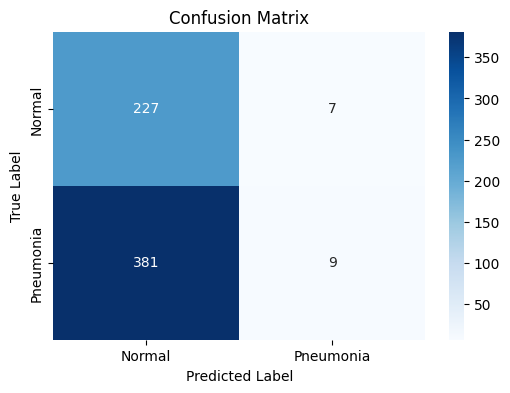

              precision    recall  f1-score   support

      Normal       0.37      0.97      0.54       234
   Pneumonia       0.56      0.02      0.04       390

    accuracy                           0.38       624
   macro avg       0.47      0.50      0.29       624
weighted avg       0.49      0.38      0.23       624



In [ ]:
def evaluate_model_with_graphs(model, test_loader, criterion):
    model.eval()
    test_loss, correct = 0.0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = correct.double() / len(test_loader.dataset)

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print(classification_report(all_labels, all_preds, target_names=['Normal', 'Pneumonia']))

# Evaluate on test set
evaluate_model_with_graphs(model, test_loader, criterion)


The confusion matrix and classification report show that the model achieved a test accuracy of 60.90%. It performs well in detecting pneumonia cases, with a recall of 97% for pneumonia but struggles significantly with identifying normal cases, as it classified all normal cases incorrectly as pneumonia. This indicates an imbalance in performance, where the model is biased toward predicting pneumonia and fails to correctly classify normal X-rays.

## 5.8 Save the Model<a id='5.8_Save_Model'></a>

Once the model is trained and evaluated, save it for future use.

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'pneumonia_detection_model.pth')
print("Model saved successfully!")

Model saved successfully!


## 5.9 Summary<a id='5.9_Summary'></a>

In this notebook, we trained a deep learning model using PyTorch to detect pneumonia from chest X-rays. We employed a pre-trained ResNet-18 model and fine-tuned it for our binary classification task. The model was trained using the Adam optimizer and evaluated on test data. We also visualized the training process using accuracy and loss graphs over epochs to assess model performance. The trained model was saved for future use.